In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick

In [2]:
client = bigquery.Client(project='subugoe-collaborative')

In [3]:
openalex_snapshot = 'subugoe-collaborative.openalex.works'
walden_snapshot = 'subugoe-collaborative.openalex_walden.works'

In [4]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=9) 
plt.rc('axes', titlesize=9) 
plt.rc('axes', labelsize=9) 
plt.rc('xtick', labelsize=9) 
plt.rc('ytick', labelsize=9) 
plt.rc('legend', fontsize=9)

In [5]:
def calculate_changes(df1_openalex, df2_walden, on):
    changes = pd.merge(df1_openalex, df2_walden, on=on, how='outer', suffixes=('_openalex', '_walden'))

    changes['n_openalex'] = changes['n_openalex'].fillna(0)
    changes['n_walden'] = changes['n_walden'].fillna(0)
    changes = changes[[on, 'n_openalex', 'n_walden']]

    changes['change'] = changes['n_walden'] - changes['n_openalex']
    changes['pct_change'] = (changes['n_walden'] - changes['n_openalex']) / changes['n_openalex'] * 100
    changes['pct_change'] = changes['pct_change'].apply(lambda x: '{:,.2f}'.format(x))

    return changes

In [7]:
oal_by_types = client.query(f"""
                             SELECT COUNT(DISTINCT(doi)) AS n, type
                             FROM `subugoe-collaborative.openalex.works`
                             WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024
                             GROUP BY type
                             ORDER BY n DESC
                             """).to_dataframe()

In [9]:
oal_by_types

,n,type
0,15610743,article
1,693450,review
2,427285,paratext
3,158396,letter
4,113624,editorial
5,72718,erratum
6,55909,dataset
7,47159,book-chapter
8,36094,reference-entry
9,21027,other


In [8]:
walden_by_types = client.query(f"""
                                SELECT COUNT(DISTINCT(doi)) AS n, type
                                FROM {walden_snapshot}
                                WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024
                                GROUP BY type
                                ORDER BY n DESC
                                """).to_dataframe()

In [10]:
walden_by_types

,n,type
0,16940674,article
1,290217,paratext
2,105042,book-chapter
3,32981,reference-entry
4,21718,other
5,14015,book
6,12399,report-component
7,3782,report
8,1492,dataset
9,251,dissertation


In [58]:
calculate_changes(oal_by_types, walden_by_types, on='type')

,type,n_openalex,n_walden,change,pct_change
0,article,15610743,16940674,1329931,8.52
1,review,693450,6,-693444,-100.00
2,paratext,427285,290217,-137068,-32.08
3,letter,158396,1,-158395,-100.00
4,editorial,113624,0,-113624,-100.00
5,erratum,72718,0,-72718,-100.00
6,dataset,55909,1492,-54417,-97.33
7,book-chapter,47159,105042,57883,122.74
8,reference-entry,36094,32981,-3113,-8.62
9,other,21027,21718,691,3.29


In [122]:
#print(calculate_changes(oal_by_types, walden_by_types, on='type').to_markdown())

In [39]:
oal_by_source_types = client.query(f"""
                                    SELECT COUNT(DISTINCT(doi)) AS n, primary_location.source.type AS source_type
                                    FROM `subugoe-collaborative.openalex.works`
                                    WHERE publication_year BETWEEN 2022 AND 2024
                                    GROUP BY source_type
                                    ORDER BY n DESC
                                    """).to_dataframe()

In [40]:
oal_by_source_types

,n,source_type
0,17281019,journal
1,3677588,None
2,3593723,repository
3,2732665,ebook platform
4,664146,book series
5,568721,conference
6,11,other


In [41]:
walden_by_source_types = client.query(f"""
                                    SELECT COUNT(DISTINCT(doi)) AS n, primary_location.source.type AS source_type
                                    FROM {walden_snapshot}
                                    WHERE publication_year BETWEEN 2022 AND 2024
                                    GROUP BY source_type
                                    ORDER BY n DESC
                                    """).to_dataframe()

In [42]:
walden_by_source_types

,n,source_type
0,35230747,repository
1,17422669,journal
2,11489134,igsnCatalog
3,6648332,None
4,1761516,ebook platform
5,662648,book series
6,301416,conference
7,135,metadata
8,63,other
9,4,raidRegistry


In [57]:
calculate_changes(oal_by_source_types, walden_by_source_types, on='source_type')

,source_type,n_openalex,n_walden,change,pct_change
0,journal,17281019,17422669,141650,0.82
1,None,3677588,6648332,2970744,80.78
2,repository,3593723,35230747,31637024,880.34
3,ebook platform,2732665,1761516,-971149,-35.54
4,book series,664146,662648,-1498,-0.23
5,conference,568721,301416,-267305,-47.00
6,other,11,63,52,472.73
7,igsnCatalog,0,11489134,11489134,inf
8,metadata,0,135,135,inf
9,raidRegistry,0,4,4,inf


In [124]:
#print(calculate_changes(oal_by_source_types, walden_by_source_types, on='source_type').to_markdown())

In [59]:
oal_by_oa = client.query(f"""
                          SELECT COUNT(DISTINCT(doi)) AS n, open_access.is_oa, open_access.oa_status
                          FROM {openalex_snapshot}
                          WHERE primary_location.source.type = 'journal' AND type = 'article' AND publication_year BETWEEN 2022 AND 2024
                          GROUP BY is_oa, oa_status
                          ORDER BY n DESC
                          """).to_dataframe()

In [60]:
oal_by_oa

,n,is_oa,oa_status
0,6396765,False,closed
1,4155508,True,gold
2,2006569,True,hybrid
3,1427168,True,bronze
4,1151659,True,diamond
5,473087,True,green


In [61]:
walden_by_oa = client.query(f"""
                             SELECT COUNT(DISTINCT(doi)) AS n, open_access.is_oa, open_access.oa_status
                             FROM {walden_snapshot}
                             WHERE primary_location.source.type = 'journal' AND type = 'article' AND publication_year BETWEEN 2022 AND 2024
                             GROUP BY is_oa, oa_status
                             ORDER BY n DESC
                             """).to_dataframe()

In [62]:
walden_by_oa

,n,is_oa,oa_status
0,6419408,False,closed
1,4426122,True,diamond
2,2982716,True,gold
3,1630570,True,hybrid
4,1008387,True,bronze
5,473677,True,green
6,15,True,closed


In [67]:
calculate_changes(oal_by_oa, walden_by_oa.groupby(['oa_status'])['n'].sum().reset_index(), on='oa_status')

,oa_status,n_openalex,n_walden,change,pct_change
0,closed,6396765,6419423,22658,0.35
1,gold,4155508,2982716,-1172792,-28.22
2,hybrid,2006569,1630570,-375999,-18.74
3,bronze,1427168,1008387,-418781,-29.34
4,diamond,1151659,4426122,3274463,284.33
5,green,473087,473677,590,0.12


In [126]:
#print(calculate_changes(oal_by_oa, walden_by_oa.groupby(['oa_status'])['n'].sum().reset_index(), on='oa_status').to_markdown())

In [70]:
oal_by_host = client.query(f"""
                            SELECT COUNT(DISTINCT(doi)) AS n, primary_location.source.host_organization_name
                            FROM {openalex_snapshot}
                            WHERE primary_location.source.type = 'journal' AND type = 'article' AND publication_year BETWEEN 2022 AND 2024
                            GROUP BY host_organization_name
                            ORDER BY n DESC
                            """).to_dataframe()

In [71]:
oal_by_host

,n,host_organization_name
0,4344384,None
1,2343634,Elsevier BV
2,735480,Springer Science+Business Media
3,723526,Multidisciplinary Digital Publishing Institute
4,688901,Wiley
...,...,...
6315,0,Georgetown University
6316,0,Allied Business Academies
6317,0,University of Iowa College of Law
6318,0,Sturm College of Law


In [68]:
walden_by_host = client.query(f"""
                             SELECT COUNT(DISTINCT(doi)) AS n, primary_location.source.host_organization_name
                             FROM {walden_snapshot}
                             WHERE primary_location.source.type = 'journal' AND type = 'article' AND publication_year BETWEEN 2022 AND 2024
                             GROUP BY host_organization_name
                             ORDER BY n DESC
                             """).to_dataframe()

In [69]:
walden_by_host

,n,host_organization_name
0,4566659,None
1,2640008,Elsevier BV
2,822804,Springer Science+Business Media
3,815693,Multidisciplinary Digital Publishing Institute
4,812110,Wiley
...,...,...
6428,0,Sweet & Maxwell
6429,0,Kennesaw State University
6430,0,Technical University of Munich
6431,0,PCM Uitgevers


In [129]:
calculate_changes(oal_by_host, walden_by_host, on='host_organization_name').sort_values(by=['n_openalex'], ascending=False).head(20)

,host_organization_name,n_openalex,n_walden,change,pct_change
0,None,4344384,4566659,222275,5.12
1,Elsevier BV,2343634,2640008,296374,12.65
2,Springer Science+Business Media,735480,822804,87324,11.87
3,Multidisciplinary Digital Publishing Institute,723526,815693,92167,12.74
4,Wiley,688901,812110,123209,17.88
5,Taylor & Francis,348443,373977,25534,7.33
6,Oxford University Press,240608,265004,24396,10.14
7,Frontiers Media,226686,288075,61389,27.08
8,Institute of Electrical and Electronics Engineers,217614,223717,6103,2.80
9,SAGE Publishing,214444,236165,21721,10.13


In [131]:
#print(calculate_changes(oal_by_host, walden_by_host, on='host_organization_name').sort_values(by=['n_openalex'], ascending=False).head(20).to_markdown())

In [76]:
calculate_changes(oal_by_host, walden_by_host, on='host_organization_name').sort_values(by=['change'], ascending=False).head(20)

,host_organization_name,n_openalex,n_walden,change,pct_change
1,Elsevier BV,2343634,2640008,296374,12.65
0,None,4344384,4566659,222275,5.12
4,Wiley,688901,812110,123209,17.88
3,Multidisciplinary Digital Publishing Institute,723526,815693,92167,12.74
2,Springer Science+Business Media,735480,822804,87324,11.87
7,Frontiers Media,226686,288075,61389,27.08
11,Lippincott Williams & Wilkins,195938,229587,33649,17.17
5,Taylor & Francis,348443,373977,25534,7.33
6,Oxford University Press,240608,265004,24396,10.14
13,BioMed Central,141830,165669,23839,16.81


In [79]:
calculate_changes(oal_by_host, walden_by_host, on='host_organization_name').sort_values(by=['change'], ascending=False).tail(20)

,host_organization_name,n_openalex,n_walden,change,pct_change
67,American Society of Civil Engineers,13175,12860,-315,-2.39
1733,United States Department of the Interior,316,0,-316,-100.00
104,EMH Swiss Medical Publishers Ltd.,7377,7053,-324,-4.39
918,NeuroQuantology,715,344,-371,-51.89
1465,New Zealand Medical Association,393,0,-393,-100.00
152,Akadémiai Kiadó,4744,4324,-420,-8.85
1033,Slavic Society of Slovenia,610,152,-458,-75.08
1054,Sociedad Argentina de Cardiología,596,93,-503,-84.40
847,Pontificia Universidad Catolica de Chile,785,266,-519,-66.11
684,National University “Odesa Law Academy”,1011,452,-559,-55.29


In [100]:
oal_by_host_references = client.query(f"""
                                      SELECT SUM(referenced_works_count) AS n, primary_location.source.host_organization_name
                                      FROM {openalex_snapshot}
                                      WHERE primary_location.source.type = 'journal' AND type = 'article' AND publication_year BETWEEN 2022 AND 2024
                                      GROUP BY host_organization_name
                                      ORDER BY n DESC
                                      """).to_dataframe()

In [101]:
oal_by_host_references

,n,host_organization_name
0,86479521,Elsevier BV
1,32402168,Multidisciplinary Digital Publishing Institute
2,31983442,None
3,27713938,Springer Science+Business Media
4,26884951,Wiley
...,...,...
6315,0,Indian Botanical Society
6316,0,Andrés Bello University
6317,0,Association française d'études chinoises
6318,0,Academy of Business & Retail Management


In [97]:
walden_by_host_references = client.query(f"""
                                          SELECT SUM(referenced_works_count) AS n, primary_location.source.host_organization_name
                                          FROM {walden_snapshot}
                                          WHERE primary_location.source.type = 'journal' AND type = 'article' AND publication_year BETWEEN 2022 AND 2024
                                          GROUP BY host_organization_name
                                          ORDER BY n DESC
                                          """).to_dataframe()

In [98]:
walden_by_host_references

,n,host_organization_name
0,109874976,Elsevier BV
1,45314021,Multidisciplinary Digital Publishing Institute
2,38616530,None
3,33460068,Springer Science+Business Media
4,32793652,Wiley
...,...,...
6428,0,AECIT
6429,0,Sofia University
6430,0,International Society of Plant Morphologists
6431,0,University of Illinois College of Law


In [134]:
#print(calculate_changes(oal_by_host_references, walden_by_host_references, on='host_organization_name').sort_values(by=['n_openalex'], ascending=False).head(20).to_markdown())

In [102]:
calculate_changes(oal_by_host_references, walden_by_host_references, on='host_organization_name').sort_values(by=['change'], ascending=False).head(20)

,host_organization_name,n_openalex,n_walden,change,pct_change
0,Elsevier BV,86479521,109874976,23395455,27.05
1,Multidisciplinary Digital Publishing Institute,32402168,45314021,12911853,39.85
2,None,31983442,38616530,6633088,20.74
4,Wiley,26884951,32793652,5908701,21.98
3,Springer Science+Business Media,27713938,33460068,5746130,20.73
6,Frontiers Media,11394387,16445860,5051473,44.33
5,Taylor & Francis,12210767,14588068,2377301,19.47
10,Institute of Electrical and Electronics Engineers,6315398,8274424,1959026,31.02
11,BioMed Central,5963888,7606606,1642718,27.54
12,Oxford University Press,5699999,7311860,1611861,28.28


In [103]:
calculate_changes(oal_by_host_references, walden_by_host_references, on='host_organization_name').sort_values(by=['change'], ascending=False).tail(20)

,host_organization_name,n_openalex,n_walden,change,pct_change
2317,Allergy and Immunology Society of Thailand,2434,0,-2434,-100.00
2267,Zoological Survey of India,2500,0,-2500,-100.00
2241,Pesticide Science Society of Japan,2539,0,-2539,-100.00
2240,United States Government Publishing Office,2541,0,-2541,-100.00
994,Başkent University,7639,5026,-2613,-34.21
2142,Society of Physicians and Naturalists,2753,0,-2753,-100.00
1954,Korean Academy of Nursing Administration,3226,0,-3226,-100.00
1408,AI Publications,5033,1440,-3593,-71.39
147,MAIK Nauka/Interperiodica,76426,72025,-4401,-5.76
1334,Sociedad Argentina de Cardiología,5307,863,-4444,-83.74


In [104]:
oal_by_pubyear = client.query(f"""
                               SELECT COUNT(DISTINCT(doi)) AS n, publication_year
                               FROM `subugoe-collaborative.openalex.works`
                               WHERE primary_location.source.type = 'journal' AND type = 'article' AND publication_year BETWEEN 2020 AND 2024
                               GROUP BY publication_year
                               ORDER BY publication_year DESC
                               """).to_dataframe()

In [105]:
oal_by_pubyear

,n,publication_year
0,5521460,2024
1,5154530,2023
2,4934761,2022
3,4935345,2021
4,4662309,2020


In [106]:
walden_by_pubyear = client.query(f"""
                                  SELECT COUNT(DISTINCT(doi)) AS n, publication_year
                                  FROM {walden_snapshot}
                                  WHERE primary_location.source.type = 'journal' AND type = 'article' AND publication_year BETWEEN 2020 AND 2024
                                  GROUP BY publication_year
                                  ORDER BY publication_year DESC
                                  """).to_dataframe()

In [107]:
walden_by_pubyear

,n,publication_year
0,5999348,2024
1,5591304,2023
2,5350076,2022
3,5307559,2021
4,5013208,2020


In [108]:
calculate_changes(oal_by_pubyear, walden_by_pubyear, on='publication_year').sort_values(by=['change'], ascending=False)

,publication_year,n_openalex,n_walden,change,pct_change
0,2024,5521460,5999348,477888,8.66
1,2023,5154530,5591304,436774,8.47
2,2022,4934761,5350076,415315,8.42
3,2021,4935345,5307559,372214,7.54
4,2020,4662309,5013208,350899,7.53


In [136]:
#print(calculate_changes(oal_by_pubyear, walden_by_pubyear, on='publication_year').sort_values(by=['change'], ascending=False).to_markdown())

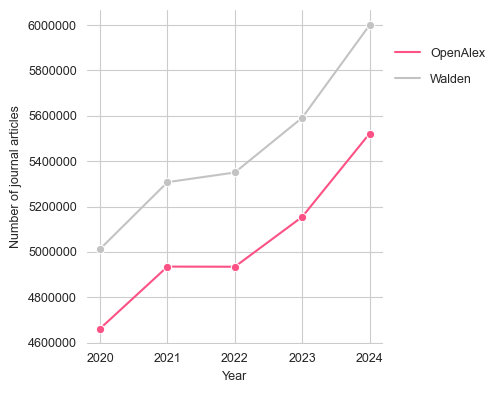

In [119]:
fig, ax = plt.subplots(figsize=(4,4))
plt.box(False)

sns.lineplot(data=oal_by_pubyear,
             x='publication_year',
             y='n',
             color='#fc5185',
             marker='o',
             ax=ax)

sns.lineplot(data=walden_by_pubyear,
             x='publication_year',
             y='n',
             color='#c3c3c3',
             marker='o',
             ax=ax)

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

ax.set(xlabel='Year', ylabel='Number of journal articles')
ax.set_xticks(range(2020,2025))

oal_patch = Line2D([0], [0], color='#fc5185', label='OpenAlex')
walden_patch = Line2D([0], [0], color='#c3c3c3', label='Walden')

lgd = fig.legend(handles=[oal_patch, walden_patch], frameon=False,
                 bbox_to_anchor=(1.25, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig('media/oal_walden_comparison_article_pubyear.png', format='png', bbox_inches='tight', dpi=500)

In [6]:
oal_by_index = client.query(f"""
                             SELECT COUNT(DISTINCT(doi)) AS n, indexed_in
                             FROM `subugoe-collaborative.openalex.works`
                             WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024
                             GROUP BY indexed_in
                             ORDER BY n DESC
                             """).to_dataframe()

In [7]:
oal_by_index

,n,indexed_in
0,12379200,[crossref]
1,3982446,"[crossref, pubmed]"
2,451029,"[crossref, doaj, pubmed]"
3,357646,"[crossref, doaj]"
4,45342,"[arxiv, crossref]"
5,40347,"[arxiv, crossref, datacite]"
6,8214,"[arxiv, crossref, pubmed]"
7,7159,"[arxiv, crossref, datacite, pubmed]"
8,4332,"[arxiv, crossref, datacite, doaj]"
9,1832,"[arxiv, crossref, doaj]"


In [26]:
oal_by_index_explode = oal_by_index.explode('indexed_in').groupby(['indexed_in'])['n'].sum().reset_index().sort_values(by=['n'], ascending=False)

In [27]:
oal_by_index_explode

,indexed_in,n
1,crossref,17280189
4,pubmed,4450770
3,doaj,816487
0,arxiv,108856
2,datacite,53932


In [8]:
walden_by_index = client.query(f"""
                                SELECT COUNT(DISTINCT(doi)) AS n, indexed_in
                                FROM {walden_snapshot}
                                WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024
                                GROUP BY indexed_in
                                ORDER BY n DESC
                                """).to_dataframe()

In [9]:
walden_by_index

,n,indexed_in
0,10357478,[crossref]
1,2590977,"[crossref, doaj]"
2,2513281,"[crossref, pubmed]"
3,1757929,"[crossref, doaj, pubmed]"
4,50219,[datacite]
5,38923,"[arxiv, crossref]"
6,23083,"[crossref, datacite, pubmed]"
7,20315,"[crossref, datacite]"
8,18636,"[crossref, datacite, doaj, pubmed]"
9,16074,"[arxiv, crossref, doaj]"


In [28]:
walden_by_index_explode = walden_by_index.explode('indexed_in').groupby(['indexed_in'])['n'].sum().reset_index().sort_values(by=['n'], ascending=False)

In [29]:
walden_by_index_explode

,indexed_in,n
1,crossref,17368810
3,doaj,4401213
4,pubmed,4323568
2,datacite,136737
0,arxiv,77103


In [30]:
calculate_changes(oal_by_index_explode, walden_by_index_explode, on='indexed_in').sort_values(by=['change'], ascending=False)

,indexed_in,n_openalex,n_walden,change,pct_change
2,doaj,816487,4401213,3584726,439.04
0,crossref,17280189,17368810,88621,0.51
4,datacite,53932,136737,82805,153.54
3,arxiv,108856,77103,-31753,-29.17
1,pubmed,4450770,4323568,-127202,-2.86


In [32]:
#print(calculate_changes(oal_by_index_explode, walden_by_index_explode, on='indexed_in').sort_values(by=['change'], ascending=False).to_markdown())

In [10]:
oal_by_index_all = client.query(f"""
                                 SELECT COUNT(DISTINCT(doi)) AS n, indexed_in
                                 FROM `subugoe-collaborative.openalex.works`
                                 WHERE publication_year BETWEEN 2022 AND 2024
                                 GROUP BY indexed_in
                                 ORDER BY n DESC
                                 """).to_dataframe()

In [11]:
oal_by_index_all

,n,indexed_in
0,21173046,[crossref]
1,4043482,"[crossref, pubmed]"
2,1194723,[datacite]
3,557047,[]
4,451148,"[crossref, doaj, pubmed]"
5,359105,"[crossref, doaj]"
6,323673,"[arxiv, datacite]"
7,213369,[arxiv]
8,56908,[pubmed]
9,51195,"[arxiv, crossref]"


In [21]:
oal_by_index_all_explode = oal_by_index_all.explode('indexed_in').groupby(['indexed_in'])['n'].sum().reset_index().sort_values(by=['n'], ascending=False)

In [22]:
oal_by_index_all_explode

,indexed_in,n
1,crossref,26149607
4,pubmed,4572091
2,datacite,1580251
3,doaj,840008
0,arxiv,659630


In [12]:
walden_by_index_all = client.query(f"""
                                SELECT COUNT(DISTINCT(doi)) AS n, indexed_in
                                FROM {walden_snapshot}
                                WHERE publication_year BETWEEN 2022 AND 2024
                                GROUP BY indexed_in
                                ORDER BY n DESC
                                """).to_dataframe()

In [13]:
walden_by_index_all

,n,indexed_in
0,41979355,[datacite]
1,19134757,[crossref]
2,3698906,[]
3,2607364,"[crossref, doaj]"
4,2572933,"[crossref, pubmed]"
5,1758722,"[crossref, doaj, pubmed]"
6,1353781,"[arxiv, datacite]"
7,136455,[doaj]
8,55395,[pubmed]
9,50469,"[arxiv, crossref]"


In [23]:
walden_by_index_all_explode = walden_by_index_all.explode('indexed_in').groupby(['indexed_in'])['n'].sum().reset_index().sort_values(by=['n'], ascending=False)

In [24]:
walden_by_index_all_explode

,indexed_in,n
2,datacite,43469621
1,crossref,26247529
3,doaj,4592343
4,pubmed,4449315
0,arxiv,1451092


In [25]:
calculate_changes(oal_by_index_all_explode, walden_by_index_all_explode, on='indexed_in').sort_values(by=['change'], ascending=False)

,indexed_in,n_openalex,n_walden,change,pct_change
2,datacite,1580251,43469621,41889370,"2,650.80"
3,doaj,840008,4592343,3752335,446.70
4,arxiv,659630,1451092,791462,119.99
0,crossref,26149607,26247529,97922,0.37
1,pubmed,4572091,4449315,-122776,-2.69


In [34]:
#print(calculate_changes(oal_by_index_all_explode, walden_by_index_all_explode, on='indexed_in').sort_values(by=['change'], ascending=False).to_markdown())